In [1]:
from numpy.random import Generator
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
from scipy.optimize import minimize 
from scipy.stats import gaussian_kde

In [2]:
config = {
    'nbase': 500,
    'neca': 2000,
}

In [3]:
def plot_dist(data1, data2, col, ax=None):
    if not ax:
        _, ax = plt.subplots(1,1)
        
    ax.hist(data1[col], density=True, fill='black', histtype='stepfilled', 
             edgecolor='black', linewidth=1.2, label=data1.name)
    ax.hist(data2[col], density=True, fill='blue', histtype='stepfilled',
             edgecolor='blue', linewidth=1.2, label=data2.name, alpha=0.7)
    ax.legend()
    ax.set_title(col)
    return 

In [4]:
# For Base cohort
age = 45
lab1 = 3.4
lab2 = 5000

mean = [age, lab1, lab2]
cov = [[14, 3, 100], 
       [3, 2, 50],
       [100, 50, 8000]]

x = np.random.default_rng().multivariate_normal(mean, cov, config['nbase'])
x[x< 0] = 0

lab3 = np.random.beta(1, 2, size=config['nbase'])
x = np.concatenate((x, lab3.reshape(config['nbase'], -1)), axis=1)

data_base = pd.DataFrame(x, columns=['age', 'lab1', 'lab2', 'lab3'])

In [5]:
# For External cohort
age = 50
lab1 = 5.5
lab2 = 4700

mean = [age, lab1, lab2]
cov = [[20, 5, 150], 
       [5, 4, 100],
       [150, 100, 55000]]

x = np.random.default_rng().multivariate_normal(mean, cov, config['neca'])
x[x< 0] = 0

lab3 = 1.5*np.random.beta(1, 2, size=config['neca'])
x = np.concatenate((x, lab3.reshape(config['neca'], -1)), axis=1)

data_eca = pd.DataFrame(x, columns=['age', 'lab1', 'lab2', 'lab3'])

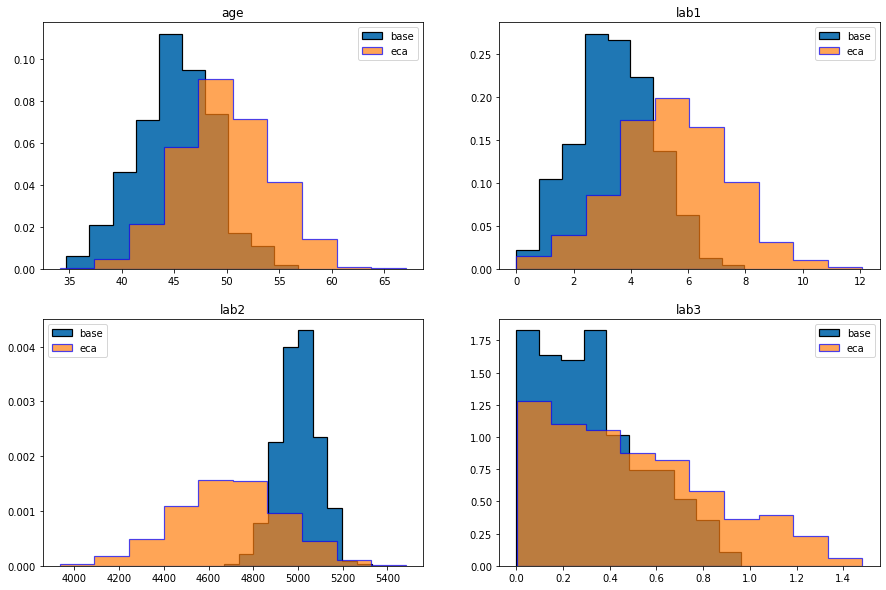

In [6]:
_, ax = plt.subplots(2,2, figsize=(15, 10))

data_base.name = 'base'
data_eca.name = 'eca'
plot_dist(data_base, data_eca, 'age', ax[0][0])
plot_dist(data_base, data_eca, 'lab1', ax[0][1])
plot_dist(data_base, data_eca, 'lab2', ax[1][0])
plot_dist(data_base, data_eca, 'lab3', ax[1][1])

In [7]:
density_age = gaussian_kde(data_base['age'])
density_lab1 = gaussian_kde(data_base['lab1'])
density_lab2 = gaussian_kde(data_base['lab2'])
density_lab3 = gaussian_kde(data_base['lab3'])

In [8]:
b = max(data_base['age'].max(), data_eca['age'].max())
a = min(data_base['age'].min(), data_eca['age'].min())
waypoints_age = np.linspace(a, b, 100)

b = max(data_base['lab1'].max(), data_eca['lab1'].max())
a = min(data_base['lab1'].min(), data_eca['lab1'].min())
waypoints_lab1 = np.linspace(a, b, 100)

b = max(data_base['lab2'].max(), data_eca['lab2'].max())
a = min(data_base['lab2'].min(), data_eca['lab2'].min())
waypoints_lab2 = np.linspace(a, b, 100)

b = max(data_base['lab3'].max(), data_eca['lab3'].max())
a = min(data_base['lab3'].min(), data_eca['lab3'].min())
waypoints_lab3 = np.linspace(a, b, 100)

In [9]:
def calc_loss(w):    
    est_den_age = gaussian_kde(data_eca['age'], weights=w)
    est_den_lab1 = gaussian_kde(data_eca['lab1'], weights=w)
    est_den_lab2 = gaussian_kde(data_eca['lab2'], weights=w)
    est_den_lab3 = gaussian_kde(data_eca['lab3'], weights=w)
    
    loss = (density_age(waypoints_age)- est_den_age(waypoints_age))**2 + \
    (density_lab1(waypoints_lab1)- est_den_lab1(waypoints_lab1))**2 + \
    (density_lab2(waypoints_lab2)- est_den_lab2(waypoints_lab2))**2 + \
    (density_lab3(waypoints_lab3)- est_den_lab3(waypoints_lab3))**2
        
    return sum(loss)

In [10]:
def noneg(x):
    return x - 0.00001

cons = ({'type': 'ineq', 'fun': noneg},
        {'type': 'eq', 'fun': lambda x: sum(x) - 1})

In [11]:
%%time
weights = 0.001*np.ones(config['neca'])

wopt = minimize(calc_loss, weights, constraints=cons, options= 
            {"disp":True,"maxiter":1000})
p = wopt.x

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.0008122761078755448
            Iterations: 80
            Function evaluations: 160163
            Gradient evaluations: 80
CPU times: user 1h 39min 32s, sys: 11.3 s, total: 1h 39min 44s
Wall time: 1h 39min 43s


In [12]:
data_eca_study = data_eca.sample(n=config['nbase'], replace=True, weights=p, 
                                 random_state=100)
data_eca_study.name = 'eca'

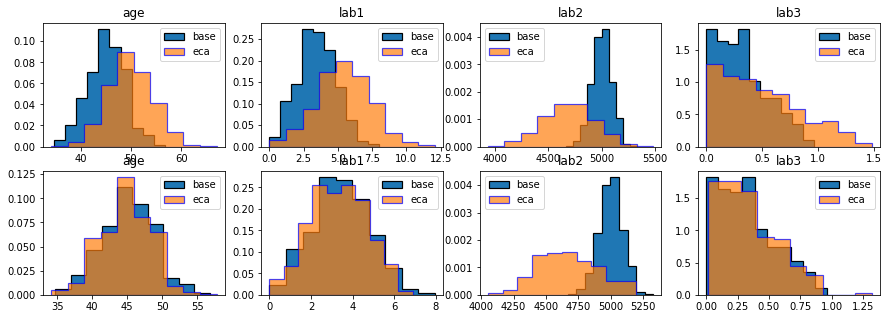

In [13]:
_, ax = plt.subplots(2,4, figsize=(15, 5))

plot_dist(data_base, data_eca, 'age', ax[0][0])
plot_dist(data_base, data_eca, 'lab1', ax[0][1])
plot_dist(data_base, data_eca, 'lab2', ax[0][2])
plot_dist(data_base, data_eca, 'lab3', ax[0][3])

plot_dist(data_base, data_eca_study, 'age', ax[1][0])
plot_dist(data_base, data_eca_study, 'lab1', ax[1][1])
plot_dist(data_base, data_eca_study, 'lab2', ax[1][2])
plot_dist(data_base, data_eca_study, 'lab3', ax[1][3])